# Cell Clustering on Nucleus Dataset

Pouya Pourakbarian Niaz - pniaz20@ku.edu.tr  
Feras Kiki - fkiki18@ku.edu.tr

## Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

## Part 1 & 2 - Feature Extraction and Clustering

### Functions

In [103]:
def calculateIntensityFeatures(patch:np.ndarray, binNumber:int):
    """
    Extract Intensity-Based features from a gray scale image patch
    
    ### Args:
    - patch (numpy array): 2D tensor of grayscale intensities
    - binNumber (int): number of bins to use for the histogram
    
    ### Returns:
        tuple: (mean, std, entropy)
    """
    # Calculate the mean and standard deviation of the patch
    mean = np.mean(patch)
    std = np.std(patch)

    # Calculate the entropy of the patch using a histogram with binNumber bins
    hist, _ = np.histogram(patch, bins=binNumber, range=[0, 255])
    hist = hist.astype(float) / np.sum(hist)
    entropy = -np.sum(hist * np.log2(hist + (hist == 0)))

    return mean, std, entropy




def calculateCooccurrenceMatrix(patch:np.ndarray, binNumber:int, di:int, dj:int):
    """Calculate normalized concurrence matrix given a patch of an image and a distance vector

    ### Args:
        - patch (Numpy array): 2D tensor of grayscale intensities
        - binNumber (int): number of bins to use for the histogram
        - di (int): distance in rows
        - dj (int): distance in columns

    ### Returns:
        - Numpy array: Normalized cooccurrence matrix
    """
    # Create a grayscale image with binNumber levels
    img = (patch * binNumber // 256).astype(int)

    # Initialize the co-occurrence matrix
    M = np.zeros((binNumber, binNumber))

    # Loop over the pixels in the patch
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Check if there are neighbors at distance (di, dj)
            if i + di < img.shape[0] and j + dj < img.shape[1]:
                # Increment the co-occurrence count for this pair of intensities
                M[img[i, j], img[i + di, j + dj]] += 1

    # Normalize the co-occurrence matrix
    M = M / np.sum(M)

    return M



def calculateAccumulatedCooccurrenceMatrix(patch:np.ndarray, binNumber:int, d:int):
    """Calculate the accumulated co-occurrence matrix for a given patch and distance value

    ### Args:
        - patch (Numpy array): 2D tensor of grayscale intensities
        - binNumber (int): number of bins to use for the histogram
        - d (int): distance to be used for the co-occurrence matrix

    ### Returns:
        - Numpy array: Accumulated co-occurrence matrix
    """
    
    # Initialize the accumulated co-occurrence matrix
    accM = np.zeros((binNumber, binNumber))

    # Loop over the distances in the list d
    for di, dj in [(d, 0), (d, d), (0, d), (-d, d), (-d, 0), (-d, -d), (0, -d), (d, -d)]:
        # Calculate the co-occurrence matrix for this distance
        M = calculateCooccurrenceMatrix(patch, binNumber, di, dj)
        # Add it to the accumulated co-occurrence matrix
        accM += M

    return accM



def calculateCooccurrenceFeatures(accM:np.ndarray):
    """Calculate the texture features from an accumulated co-occurrence matrix

    ### Args:
        - accM (Numpy ): Accumulated co-occurrence matrix

    ### Returns:
        - Tuple: (Angular Second Moment, Maximum Probability, Inverse Difference Moment, Entropy)
    """
    # Normalize the accumulated co-occurrence matrix
    norm_accM = accM / np.sum(accM)

    # Calculate the texture features on the normalized matrix
    asm = np.sum(norm_accM ** 2)
    max_prob = np.max(norm_accM)
    idm = np.sum(norm_accM / (1 + np.arange(norm_accM.shape[0])) ** 2)
    entropy = -np.sum(norm_accM * np.log2(norm_accM + (norm_accM == 0)))

    return (asm, max_prob, idm, entropy)



def extractFeatures(image_file:str, dataframe:pd.DataFrame, window_size:int, bin_number:int, distance:int):
    """Extract features from a given image and a list of coordinates

    ### Args:
        - image_file (str): Path to the image file
        - dataframe (Pandas Data Frame): Data frame with the coordinates of the points
        - window_size (int): Window size for exrtacting the patches around the cell coordinates
        - bin_number (int): Number of bins to use for the histograms
        - distance (int): Distance to be used for the co-occurrence matrix

    ### Returns:
        - Pandas DataFrame with the features
    """
    
    # Read image and convert to grayscale
    image = cv2.imread(image_file)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define the feature vector
    features = np.empty((len(dataframe), 7))

    # Loop over the coordinates in the dataframe
    for index, row in dataframe.iterrows():
        x, y = row['X'], row['Y']

        # Crop patch from grayscale image
        half_window_size = window_size // 2
        patch = gray_image[y - half_window_size: y + half_window_size + 1, x - half_window_size: x + half_window_size + 1]

        # Extract intensity-based features
        intensityFeat = calculateIntensityFeatures(patch, bin_number)

        # Accumulate co-occurrence matrix
        accM = calculateAccumulatedCooccurrenceMatrix(patch, bin_number, distance)

        # Extract texture-based features
        texturalFeat = calculateCooccurrenceFeatures(accM)

        # Concatenate features
        features[index, :] = np.concatenate((intensityFeat, texturalFeat))

    return pd.DataFrame(features, columns=['mean', 'std', 'intensity_entropy', 'angular_second_moment', 'maximum_probability', 'inverse_difference_moment', 'texture_entropy'])





def extractFeaturesFromAllImages(image_filenames:list, window_size:int, bin_number:int, d:int):
    """Extract features from all images in the dataset folder

    ### Args:
        - image_filenames (list): list of strings with only image names, without any extensions. The text files containing data will be read automatically.
        - window_size (int): size of the window to be used for extracting the patches around the cell coordinates
        - bin_number (int): number of bins to use for the histograms
        - d (int): Distance value to be used in extracting the accumulated cooccurrence matrix.

    ### Returns:
        - Tuple: (X, y, class_labels)
    """
    X = []
    Y = []
    class_labels = set()
    label_encoder = LabelEncoder()

    for filename in image_filenames:
        # Read image
        img = cv2.imread(os.path.join("nucleus-dataset", filename + ".png"), cv2.IMREAD_GRAYSCALE)

        # Read corresponding text file and extract coordinates and labels
        text_filename = os.path.join("nucleus-dataset", filename + '_cells')
        df = pd.read_csv(text_filename, sep='\t', header=None, names=['X', 'Y', 'Label'])

        # Extract features for each cell in the image
        for i, row in df.iterrows():
            x = int(row['X'])
            y = int(row['Y'])
            label = row['Label']

            # Crop image patch around the cell
            patch = img[y - window_size // 2:y + window_size // 2 + 1, x - window_size // 2:x + window_size // 2 + 1]

            # Extract intensity features
            intensity_features = calculateIntensityFeatures(patch, bin_number)

            # Extract co-occurrence matrix and texture features
            accM = calculateAccumulatedCooccurrenceMatrix(patch, bin_number, d)
            texture_features = calculateCooccurrenceFeatures(accM)

            # Concatenate features into a single feature vector
            features = np.concatenate((intensity_features, texture_features))

            # Append feature vector and label to training data
            X.append(features)
            Y.append(label)
        
        # Add unique labels to class labels list
        for label in np.unique(df['Label']):
            class_labels.add(label)

    # Convert labels to 0-indexed integers
    Y = label_encoder.fit_transform(Y)
    
    class_labels = list(class_labels)

    return np.array(X), np.array(Y), class_labels




def kmeans_clustering(X:np.ndarray, y:np.ndarray, n_clusters:int):
    """Train K means clustering model on the data and assign class labels to each cluster

    ### Args:
        - X (Numpy array): Feature matrix where every row is a cell and every column is a feature
        - y (Numpy array): Labels for each cell
        - n_clusters (int): Number of clusters to use for K-means clustering

    ### Returns:
        - dict: Dictionary with the following fields:
            - model: Trained K-means clustering model
            - cluster_to_label: Dictionary that maps from cluster labels to class labels as per the ground truth of the training set.
            - assigned_labels: List of assigned labels for all data in the training set. 
            - scaler: MinMaxScaler object used for normalizing the data.
    """
    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_norm)
    
    # Make a dictionary that maps from clustering labels defined by kmeans, to the true assigned labels.
    cluster_to_label = {}

    # Get the cluster labels
    cluster_labels = kmeans.labels_

    # Assign class labels based on the majority label in each cluster
    assigned_labels = np.zeros(len(X), dtype=int)
    for i in range(n_clusters):
        cluster_indices = np.where(cluster_labels == i)[0]
        labels = y[cluster_indices]
        counts = np.bincount(labels)
        cluster_to_label[i] = np.argmax(counts)
        assigned_labels[cluster_indices] = cluster_to_label[i]

    
    
    # Return clustering results and assigned labels
    return {'model':kmeans, 'cluster_to_label':cluster_to_label, 'assigned_labels':assigned_labels, 'scaler':scaler}



def predict_with_labels(x:np.ndarray, kmeans_output:dict):
    """Perform prediction on the data using the trained K-means clustering model and the assigned labels.
    This function assigns labels corresponding to the label indices introduces by the ground truth training labels to a given input matrix.

    ### Args:
        - x (Numpy array): Feature matrix where every row is a cell and every column is a feature
        - kmeans_output (dict): Dictionary containing the output of the K means clustering returned by the `kmeans_clustering` function.

    ### Returns:
        - Numpy array: Output assigned labels according to the label indices given in the ground truth training labels.
    """
    model = kmeans_output['model']
    scaler = kmeans_output['scaler']
    cluster_to_label = kmeans_output['cluster_to_label']
    
    # Normalize the data using MinMaxScaler
    x_norm = scaler.transform(x)
    
    # Predict the cluster labels
    cluster_labels = model.predict(x_norm)
    
    # Map the cluster labels to the assigned labels
    assigned_labels = np.array([cluster_to_label[i] for i in cluster_labels])
    
    return assigned_labels

### Implementation

In [318]:
# Get the raw names of the training and testing images
training_images = [filename.split('.')[0] for filename in os.listdir("nucleus-dataset") if (filename.endswith('.png') and 'train' in filename)]
testing_images = [filename.split('.')[0] for filename in os.listdir("nucleus-dataset") if (filename.endswith('.png') and 'test' in filename)]
print("training images: ")
print(training_images)
print('')
print("testing images:")
print(testing_images)

training images: 
['train_11', 'train_14', 'train_21', 'train_8']

testing images:
['test_1', 'test_10']


In [627]:
# Hyper_parameters #1
# WINDOW_SIZE = 15
# BIN_NUMBER = 16
# DISTANCE = 1

# # Choose the hyperparameters
WINDOW_SIZE = 30
BIN_NUMBER = 25
DISTANCE = 5
sampling_type= 'equal'
n_clusters_predict = 5

In [629]:
# Generate training and testing inputs and outputs
X_train, y_train, class_labels = extractFeaturesFromAllImages(training_images, window_size=WINDOW_SIZE, bin_number=BIN_NUMBER, d=DISTANCE)
X_test, y_test, _ = extractFeaturesFromAllImages(testing_images, window_size=WINDOW_SIZE, bin_number=BIN_NUMBER, d=DISTANCE)

X_test1, y_test1, _ = extractFeaturesFromAllImages([testing_images[0]], window_size=WINDOW_SIZE, bin_number=BIN_NUMBER, d=DISTANCE)
X_test2, y_test2, _ = extractFeaturesFromAllImages([testing_images[1]], window_size=WINDOW_SIZE, bin_number=BIN_NUMBER, d=DISTANCE)


print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print("class labels: ", class_labels)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print("class labels: ", class_labels)

X_train shape:  (1602, 7)
y_train shape:  (1602,)
X_test shape:  (1580, 7)
y_test shape:  (1580,)
class labels:  ['epithelial', 'spindle', 'inflammation']
X_train shape:  (1602, 7)
y_train shape:  (1602,)
X_test shape:  (1580, 7)
y_test shape:  (1580,)
class labels:  ['epithelial', 'spindle', 'inflammation']


## Part 3 - Experimentation

In [650]:
def oversample_data(X_train, y_train, sampling_ratio='equal'):
    """
    Oversample the training data based on the specified sampling ratio.

    Args:
    X_train : numpy.ndarray, shape (n_samples, n_features)
        Training data.
    y_train : numpy.ndarray, shape (n_samples,)
        Training labels.
    sampling_ratio: str, optional (default='equal')
        The desired sampling ratio for oversampling. Must be one of ['equal', 'proportional', 'inverse_proportional'].

    Returns:
    X_train_oversampled : numpy.ndarray, shape (n_samples_oversampled, n_features)
        Oversampled training data.
    y_train_oversampled : numpy.ndarray, shape (n_samples_oversampled,)
        Oversampled training labels.
    """
    assert sampling_ratio in ['equal', 'proportional', 'inverse_proportional'], "Invalid sampling ratio"

    # Convert data to pandas DataFrame
    df = pd.DataFrame(X_train)
    df['Label'] = y_train

    # Find number of samples in majority class
    majority_samples = df['Label'].value_counts().max()

    # Separate DataFrame by class
    dfs = [df[df['Label'] == label] for label in np.unique(y_train)]

    # Calculate ratios based on sampling ratio option
    if sampling_ratio == 'equal':
        ratios = [1] * len(dfs)
    elif sampling_ratio == 'proportional':
        ratios = [len(class_df) / majority_samples for class_df in dfs]
    else:  # 'inverse_proportional'
        ratios = [1 / (len(class_df) / majority_samples) for class_df in dfs]

    # Oversample each class according to its ratio
    dfs_oversampled = [class_df.sample(int(majority_samples * ratio), replace=True) for class_df, ratio in zip(dfs, ratios)]

    # Concatenate the oversampled DataFrames
    df_oversampled = pd.concat(dfs_oversampled)

    # Extract the oversampled data
    X_train_oversampled = df_oversampled.drop(['Label'], axis=1).values
    y_train_oversampled = df_oversampled['Label'].values

    return X_train_oversampled, y_train_oversampled

# # Apply the function to your data
X_train_oversampled, y_train_oversampled = oversample_data(X_train, y_train, sampling_ratio=sampling_type)


In [651]:
# show how many samples are in each class
print("Number of samples in each class before oversampling: ", np.bincount(y_train_oversampled))

Number of samples in each class before oversampling:  [778 778 778]


In [653]:
# Train K-means clustering model and predict on the test set

kmeans_output = kmeans_clustering(X_train_oversampled, y_train_oversampled, n_clusters=n_clusters_predict)
y_train_pred = kmeans_output['assigned_labels']
y_test_pred = predict_with_labels(X_test, kmeans_output)

In [655]:
# Evaluate model on training and testing sets

train_acc = accuracy_score(y_train_oversampled, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Training accuracy: ", round(train_acc*100,3),'%')
print("Testing accuracy: ", round(test_acc*100,3), '%')

Training accuracy:  73.008 %
Testing accuracy:  69.114 %


In [656]:
# write proportion of y_train_pred and y_test_pred and round the number to 3 decimal places
print("Proportion of y_train: ", np.round(np.bincount(y_train)/len(y_train), 3))
print("Proportion of y_train_pred: ", np.round(np.bincount(y_train_pred)/len(y_train_pred), 3))

print("Proportion of y_test_pred: ",  np.round(np.array([np.sum(y_test_pred == 0), np.sum(y_test_pred == 1), np.sum(y_test_pred== 2)])/len(y_test_pred), 3 ))
print("Proportion of y_truth: ", np.round(np.array([np.sum(y_test == 0), np.sum(y_test == 1), np.sum(y_test== 2)])/len(y_test), 3 ))
# write number of y_train_pred and y_test_pred

print("Number of y_test_pred: ", [np.sum(y_test_pred == 0), np.sum(y_test_pred == 1), np.sum(y_test_pred == 2)])
print("Number of y_truth: ", [np.sum(y_test == 0), np.sum(y_test == 1), np.sum(y_test== 2)])



Proportion of y_train:  [0.376 0.138 0.486]
Proportion of y_train_pred:  [0.51  0.247 0.243]
Proportion of y_test_pred:  [0.234 0.43  0.337]
Proportion of y_truth:  [0.328 0.215 0.457]
Number of y_test_pred:  [369, 679, 532]
Number of y_truth:  [519, 339, 722]


In [657]:
def read_text_file(path):
    with open(path, 'r') as file:
        contents = file.read()
    return contents

cells= [os.path.join("nucleus-dataset", testing_images[0] + '_cells'), os.path.join("nucleus-dataset", testing_images[1] + '_cells')]
Label_map = {'epithelial': 0, 'spindle': 1, 'inflammation': 2}
cells_dict = {}
for i in range(len(cells)):
    cells_dict[i] = []
    c1= read_text_file(cells[i]).split("\n")
    for j in range(len(c1)):
        cells_dict[i].append(c1[j].split("\t"))
    cells_dict[i].pop()
    for j in range(len(cells_dict[i])):
        cells_dict[i][j][0] = int(cells_dict[i][j][0])
        cells_dict[i][j][1] = int(cells_dict[i][j][1])
        cells_dict[i][j][2] = Label_map[cells_dict[i][j][2]]


image_cells = []
for i in range(len(cells_dict)):
    cell_line= []
    for j in range(len(cells_dict[i])):
        cell_line.append( cells_dict[i][j][:])

    image_cells.append(np.array(cell_line))


def plot_colored_cells(image_cells, img_label, plot_cell_size= 3):
        plt.scatter(image_cells[img_label==0].T[0], image_cells[img_label==0].T[1], s=plot_cell_size, c='b')
        plt.scatter(image_cells[img_label==1].T[0], image_cells[img_label==1].T[1], s= plot_cell_size, c='g')
        plt.scatter(image_cells[img_label==2].T[0], image_cells[img_label==2].T[1], s= plot_cell_size, c='r')


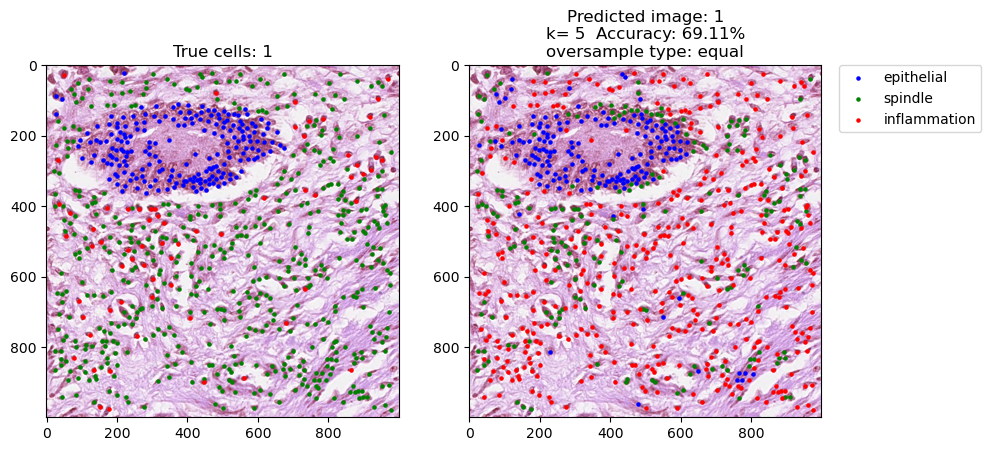

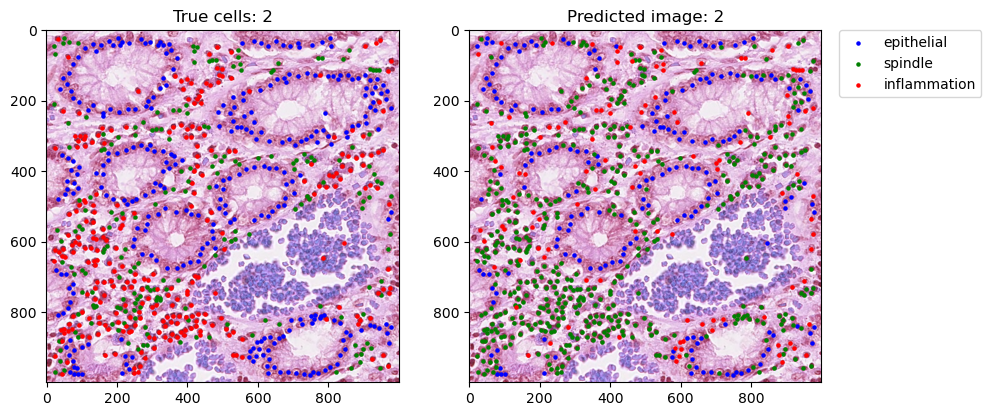

In [658]:
# Create a figure with 1 row and 2 columns of subplots, with a size of 10x5 inches
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
imgs = [
    cv2.imread(os.path.join("nucleus-dataset", testing_images[0] + ".png")),
    cv2.imread(os.path.join("nucleus-dataset", testing_images[1] + ".png"))
]
# Configure the first subplot in the grid (1 row, 2 columns), and activate it
plt.subplot(1, 2, 1)

plt.imshow(imgs[0])
y_test_pred = predict_with_labels(X_test1, kmeans_output)

plot_colored_cells(image_cells[0], image_cells[0].T[2], 5)

plt.title("True cells: 1")

plt.subplot(1, 2, 2)

plt.imshow(imgs[0])

y_test_pred = predict_with_labels(X_test1, kmeans_output)

plot_colored_cells(image_cells[0], y_test_pred, 5)

plt.title("Predicted image: 1" + "\n" + "k= " + str(n_clusters_predict) + "  Accuracy: " + str( np.round(100 *test_acc, 2)) + "%" + "\n" + "oversample type: " + sampling_type)

# Add a legend with labels for the colors outside of the plot
plt.legend(['epithelial', 'spindle', 'inflammation'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.imshow(imgs[1])
y_test_pred = predict_with_labels(X_test2, kmeans_output)

plot_colored_cells(image_cells[1], image_cells[1].T[2], 5)

plt.title("True cells: 2")

plt.subplot(1, 2, 2)

plt.imshow(imgs[1])

y_test_pred = predict_with_labels(X_test2, kmeans_output)

plot_colored_cells(image_cells[1], y_test_pred, 5)

plt.title("Predicted image: 2" )

# Add a legend with labels for the colors outside of the plot
plt.legend(['epithelial', 'spindle', 'inflammation'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Part 4 - Transfer Learning

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from torch import optim
from torchvision import transforms, utils
from PIL import Image,ImageFile, ImageOps
import cv2
import shutil
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import albumentations as A
import torchvision.models as models
import torch.nn as nn
import segmentation_models_pytorch as smp

print('CUDA available:', torch.cuda.is_available())

In [ ]:
transform_train = A.Compose([
    A.Resize(1024, 1024),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.25),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = A.Compose([
    A.Resize(1024, 1024),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask


class CellDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(img_dir)
        self.label_map = {'spindle': 0, 'epithelial': 1, 'inflammation': 2}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_path = os.path.join(self.mask_dir, base_name)  # No extension

        image = Image.open(img_path).convert("RGB")
        # Resize or pad the image to be 1024x1024
        image = ImageOps.pad(image, (1024, 1024))

        # Convert PIL Image to numpy array
        image = np.array(image)
        
        # Create an empty mask of zeros
        mask = np.zeros((1024, 1024, len(self.label_map)), dtype=np.float32)  # change the number of channels depending on your number of classes
        
        c1 = read_text_file(mask_path+ "_cells").split("\n")
        for line in c1:
            values = line.split("\t")
            if len(values) == 3:
                x, y, label = values
                x, y, label = int(x), int(y), self.label_map[label]

                # Draw a circle of radius 5 (or whatever size is appropriate) around each cell center
                window_size = 10  # Modify here based on your cell size
                mask_disk = create_circular_mask(2*window_size, 2*window_size, center=(window_size, window_size), radius=window_size)
                mask[y-window_size:y+window_size, x-window_size:x+window_size, label] = mask_disk

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        
        image = np.transpose(image, (2, 0, 1))  # Change (H, W, C) to (C, H, W)
        mask = np.transpose(mask, (2, 0, 1))  # Change (H, W, C) to (C, H, W)

        return image, mask


In [ ]:
# create a dataset object
path_train= path1+ "data_0/train/" 
path_test= path1+ "data_0/test/" 
data_train = CellDataset(path_train +  "img", path_train + "cells")
data_test = CellDataset(path_test +  "img", path_test + "cells")
data_train[0][1].shape
data_test[0][1].shape
#

In [ ]:
def build_model():
    base_model = models.resnet18(pretrained=True)
    base_model = nn.Sequential(*list(base_model.children())[:-2])

    model = UNet(base_model, out_channels=3)
    return model


# Create the model
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)


In [ ]:
def collate_fn(batch):
    images, masks = zip(*batch)  # unzip the batch
    images = [torch.from_numpy(img).float() for img in images]
    masks = [torch.from_numpy(mask).float() for mask in masks]
    return torch.stack(images), torch.stack(masks)

# import data loader
from torch.utils.data import DataLoader

# You might need to adjust the batch size according to your memory availability
loader = DataLoader(data_train, batch_size=1, collate_fn=collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)

num_epochs = 60  # select appropriate number based on your problem

for epoch in range(num_epochs):
    for images_nn, masks in loader:
        images_nn = images_nn.to(device)
        masks = masks.to(device)
        outputs = model(images_nn)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
model.eval()  
loader_test = DataLoader(data_test, batch_size=1, collate_fn=collate_fn)

with torch.no_grad():
    for images, masks in loader_test:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        # Calculate metrics here

print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

def get_metrics(outputs, masks):
    # Apply sigmoid activation to get the probabilities
    preds = torch.sigmoid(outputs)

    # Get the predicted class (0, 1, or 2)
    preds = torch.argmax(preds, dim=1).cpu().numpy().flatten()
    masks = torch.argmax(masks, dim=1).cpu().numpy().flatten()

    # Calculate metrics
    accuracy = accuracy_score(masks, preds)
    precision = precision_score(masks, preds, average='weighted')
    recall = recall_score(masks, preds, average='weighted')
    f1 = f1_score(masks, preds, average='weighted')

    return accuracy, precision, recall, f1

model.eval()
loader_test = DataLoader(data_test, batch_size=1, collate_fn=collate_fn)

In [ ]:

import matplotlib.colors as mcolors

# Create a colormap
colors = [(1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1)]  # W -> R -> G -> B
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors, N=4)

for i, (images, masks) in enumerate(loader_test):
    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images)
    
    accuracy, precision, recall, f1 = get_metrics(outputs, masks)
    print(f"Image {i}:")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")
    
    # Plot the original image, true mask, and predicted mask
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    # Normalize the image to [0, 1] range if not already
    img = images[0].cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    ax[0].imshow(img.transpose(1, 2, 0))  # Original Image
    ax[1].imshow(torch.argmax(masks[0], dim=0).cpu().numpy(), cmap=cmap)  # True mask
    ax[2].imshow(torch.argmax(torch.sigmoid(outputs[0]), dim=0).detach().cpu().numpy(), cmap=cmap)  # Predicted mask

    
    plt.show()


In [ ]:
def calculate_class_distribution_and_accuracy(true, pred):
    unique, counts = np.unique(pred, return_counts=True)
    prediction_distribution = counts / len(pred)
    
    accuracy_per_class = []
    for class_id in np.unique(true):
        correct = np.sum((pred == class_id) & (true == class_id))
        total = np.sum(true == class_id)
        accuracy = correct / total
        accuracy_per_class.append(accuracy)

    return prediction_distribution, accuracy_per_class

# ...
all_metrics = []

for i, (images, masks) in enumerate(loader_test):
    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images)

    accuracy, precision, recall, f1, prediction_distribution, accuracy_per_class = get_metrics(outputs, masks)
    all_metrics.append({
        'image_id': i,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'prediction_distribution': prediction_distribution,
        'accuracy_per_class': accuracy_per_class,
    })
    
    # ...
    
# Print the metrics at the end
for metrics in all_metrics:
    print(f"Image {metrics['image_id']}:")
    print(f"Accuracy: {metrics['accuracy']}, Precision: {metrics['precision']}, Recall: {metrics['recall']}, F1: {metrics['f1']}")
    print("Clusters ratio test predicted:\t{:.3f}\t{:.3f}\t{:.3f}".format(*metrics['prediction_distribution']))
    print("Accuracy per class:\t{:.3f}\t{:.3f}\t{:.3f}".format(*metrics['accuracy_per_class']))
